In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,matplotlib,sklearn,pandas,torch

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.27.0

numpy     : 1.26.4
scipy     : 1.13.1
matplotlib: 3.9.2
sklearn   : 1.5.2
pandas    : 2.2.2
torch     : 2.3.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary  # For model summary
import time
import torch.nn as nn


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


In [3]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
set_all_seeds(42)

In [5]:
random_seed = 42
batch_size = 16
num_epochs = 10
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
import torch

print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available devices: {torch.cuda.device_count()}")
# print(f"Device name: {torch.cuda.get_device_name(0)}")
torch.cuda.empty_cache()


False
Available devices: 0


In [7]:
# Define the transformations (resize and conversion to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor()           # Convert to tensor for processing
])

# Set the paths for the training and testing directories
output_dir_base = './reduced_data'
train_dir = os.path.join(output_dir_base, 'train')
test_dir = os.path.join(output_dir_base, 'test')

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Training or testing directory not found.")

# Load the training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create the training DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print("Numer of training samples: ", len(train_loader))
# Create the testing DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the size of training and testing datasets
print(f'Total training samples: {len(train_dataset)}')
print(f'Total testing samples: {len(test_dataset)}')

# Print class labels (to confirm that subdirectories are used as class labels)
print(f'Class labels: {train_dataset.classes}')

# Example: Print the number of batches in each DataLoader
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of testing batches: {len(test_loader)}')

# Verify class-to-index mapping
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

Numer of training samples:  10
Total training samples: 160
Total testing samples: 40
Class labels: ['sparrow', 'swan']
Number of training batches: 10
Number of testing batches: 3
{'sparrow': 0, 'swan': 1}
{'sparrow': 0, 'swan': 1}


In [8]:
# count numbers for each class
class_counts = {}
for images, labels in train_loader:
    for label in labels:
        label = label.item()
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

print(class_counts)

{1: 80, 0: 80}


### VGG 1 Block

In [9]:
class VGG1Block(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG1Block, self).__init__()
        
        # A single convolutional layer followed by max pooling
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with a 2x2 kernel
        )
        
        # Fully connected layers
        # After the Conv2d + MaxPool2d, the size will be reduced by a factor of 2 (224 -> 112)
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 112 * 112, 128),  # Adjust size for 112x112 after max pooling
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
        
    #     # Apply Kaiming uniform initialization
    #     self._initialize_weights()

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    #             torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
    #             if m.bias is not None:
    #                 m.bias.detach().zero_()

    def forward(self, x):
        x = self.block_1(x)
        x = self.fc_block(x)
        return x

# Create the model
model = VGG1Block()

# Print the summary of the model
summary(model, (3, 224, 224))  # Input size of 224x224x3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
           Flatten-4               [-1, 401408]               0
            Linear-5                  [-1, 128]      51,380,352
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
           Sigmoid-8                    [-1, 1]               0
Total params: 51,381,377
Trainable params: 51,381,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 30.63
Params size (MB): 196.00
Estimated Total Size (MB): 227.21
----------------------------------------------------------------


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
import shutil



def clear_runs_directory():
    runs_dir = "runs"
    if os.path.exists(runs_dir):
        shutil.rmtree(runs_dir)  # Deletes the entire `runs` directory
    os.makedirs(runs_dir)  # Recreates an empty `runs` directory


def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, batch_size=16, learning_rate=1e-4):
    clear_runs_directory()


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model_name = model.__class__.__name__

    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # TensorBoard writers

    writer_train = SummaryWriter(f"runs/{model_name}_Train")
    writer_test = SummaryWriter(f"runs/{model_name}_Test")

    # Log model graph
    images, _ = next(iter(train_loader))
    writer_train.add_graph(model, images.to(device))

    # Initialize tracking variables
    step_train, step_test = 0, 0
    total_training_time = 0
    epoch_train_losses, epoch_train_accuracies, epoch_test_accuracies = [], [], []

    # Training and evaluation loop
    for epoch in range(num_epochs):
        model.train()
        iter_train_losses, iter_train_accuracies = [], []

        start_time = time.time()
        for batch_idx, (data, targets) in enumerate(train_loader):
            

            data, targets = data.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            iter_train_losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training accuracy
            predictions = (scores > 0.5).float()
            correct = (predictions == targets).sum().item()
            train_accuracy = correct / data.shape[0]
            iter_train_accuracies.append(train_accuracy)

            # Log to TensorBoard for training
            writer_train.add_scalar("Loss", loss.item(), global_step=step_train)
            writer_train.add_scalar("Accuracy", train_accuracy, global_step=step_train)
            step_train += 1
            # print(step_train)
            
        end_time = time.time()
        total_training_time += end_time - start_time

        # Test phase
        model.eval()
        iter_test_accuracies = []
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32).unsqueeze(1)

                # Forward pass
                scores = model(data)

                # Test accuracy
                predictions = (scores > 0.5).float()
                correct = (predictions == targets).sum().item()
                test_accuracy = correct / data.shape[0]
                iter_test_accuracies.append(test_accuracy)

                # Log to TensorBoard for testing
                writer_test.add_scalar("Accuracy", test_accuracy, global_step=step_test)
                step_test += 1
        # print(step_test)

        # Calculate and print the epoch metrics
        avg_train_loss = sum(iter_train_losses) / len(iter_train_losses)
        avg_train_acc = sum(iter_train_accuracies) / len(iter_train_accuracies)
        avg_test_acc = sum(iter_test_accuracies) / len(iter_test_accuracies)
        
        print(f"\nEpoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {avg_train_acc:.4f}, "
              f"Test Accuracy: {avg_test_acc:.4f}")

        epoch_train_losses.append(avg_train_loss)
        epoch_train_accuracies.append(avg_train_acc)
        epoch_test_accuracies.append(avg_test_acc)

    print(f"\n------------\nTotal Training Time: {total_training_time:.2f} seconds\n-------------\n")

    # Close the writers
    writer_train.close()
    writer_test.close()

    return epoch_train_losses, epoch_train_accuracies, epoch_test_accuracies


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



# Plot training loss and accuracy
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Testing Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot predictions on test data
def plot_test_predictions(model, test_loader, num_images=40, device='cpu'):
    writer_images = SummaryWriter(f"runs/{model.__class__name}_Train")
    model.eval()
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if len(images) >= num_images:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy()

            images.extend(inputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds)

    fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(16, 10))
    fig.suptitle("True and Predicted Labels on Test Images", fontsize=16)
    
    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            ax.imshow(images[idx].transpose(1, 2, 0).squeeze(), cmap="gray")
            ax.axis("off")
            true_label = int(true_labels[idx])
            predicted_label = int(predicted_labels[idx].squeeze())
            ax.set_title(f"True: {true_label} | Pred: {predicted_label}", color="green" if true_label == predicted_label else "red")
        else:
            ax.axis("off")


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels).squeeze().astype(int)
    accuracy = np.sum(true_labels == predicted_labels) / len(true_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    return true_labels, predicted_labels

# Plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



Epoch [1/30] - Train Loss: 1.2448, Train Accuracy: 0.5875, Test Accuracy: 0.7292

Epoch [2/30] - Train Loss: 0.4937, Train Accuracy: 0.7312, Test Accuracy: 0.7292

Epoch [3/30] - Train Loss: 0.4084, Train Accuracy: 0.8313, Test Accuracy: 0.7708

Epoch [4/30] - Train Loss: 0.4487, Train Accuracy: 0.7875, Test Accuracy: 0.7500

Epoch [5/30] - Train Loss: 0.3975, Train Accuracy: 0.8063, Test Accuracy: 0.7083

Epoch [6/30] - Train Loss: 0.2816, Train Accuracy: 0.8875, Test Accuracy: 0.7500

Epoch [7/30] - Train Loss: 0.2867, Train Accuracy: 0.8938, Test Accuracy: 0.7500

Epoch [8/30] - Train Loss: 0.2301, Train Accuracy: 0.9313, Test Accuracy: 0.7917

Epoch [9/30] - Train Loss: 0.2226, Train Accuracy: 0.9375, Test Accuracy: 0.7708

Epoch [10/30] - Train Loss: 0.2252, Train Accuracy: 0.9062, Test Accuracy: 0.7083

Epoch [11/30] - Train Loss: 0.2624, Train Accuracy: 0.8938, Test Accuracy: 0.7083

Epoch [12/30] - Train Loss: 0.2092, Train Accuracy: 0.9062, Test Accuracy: 0.7917

Epoch [13/30

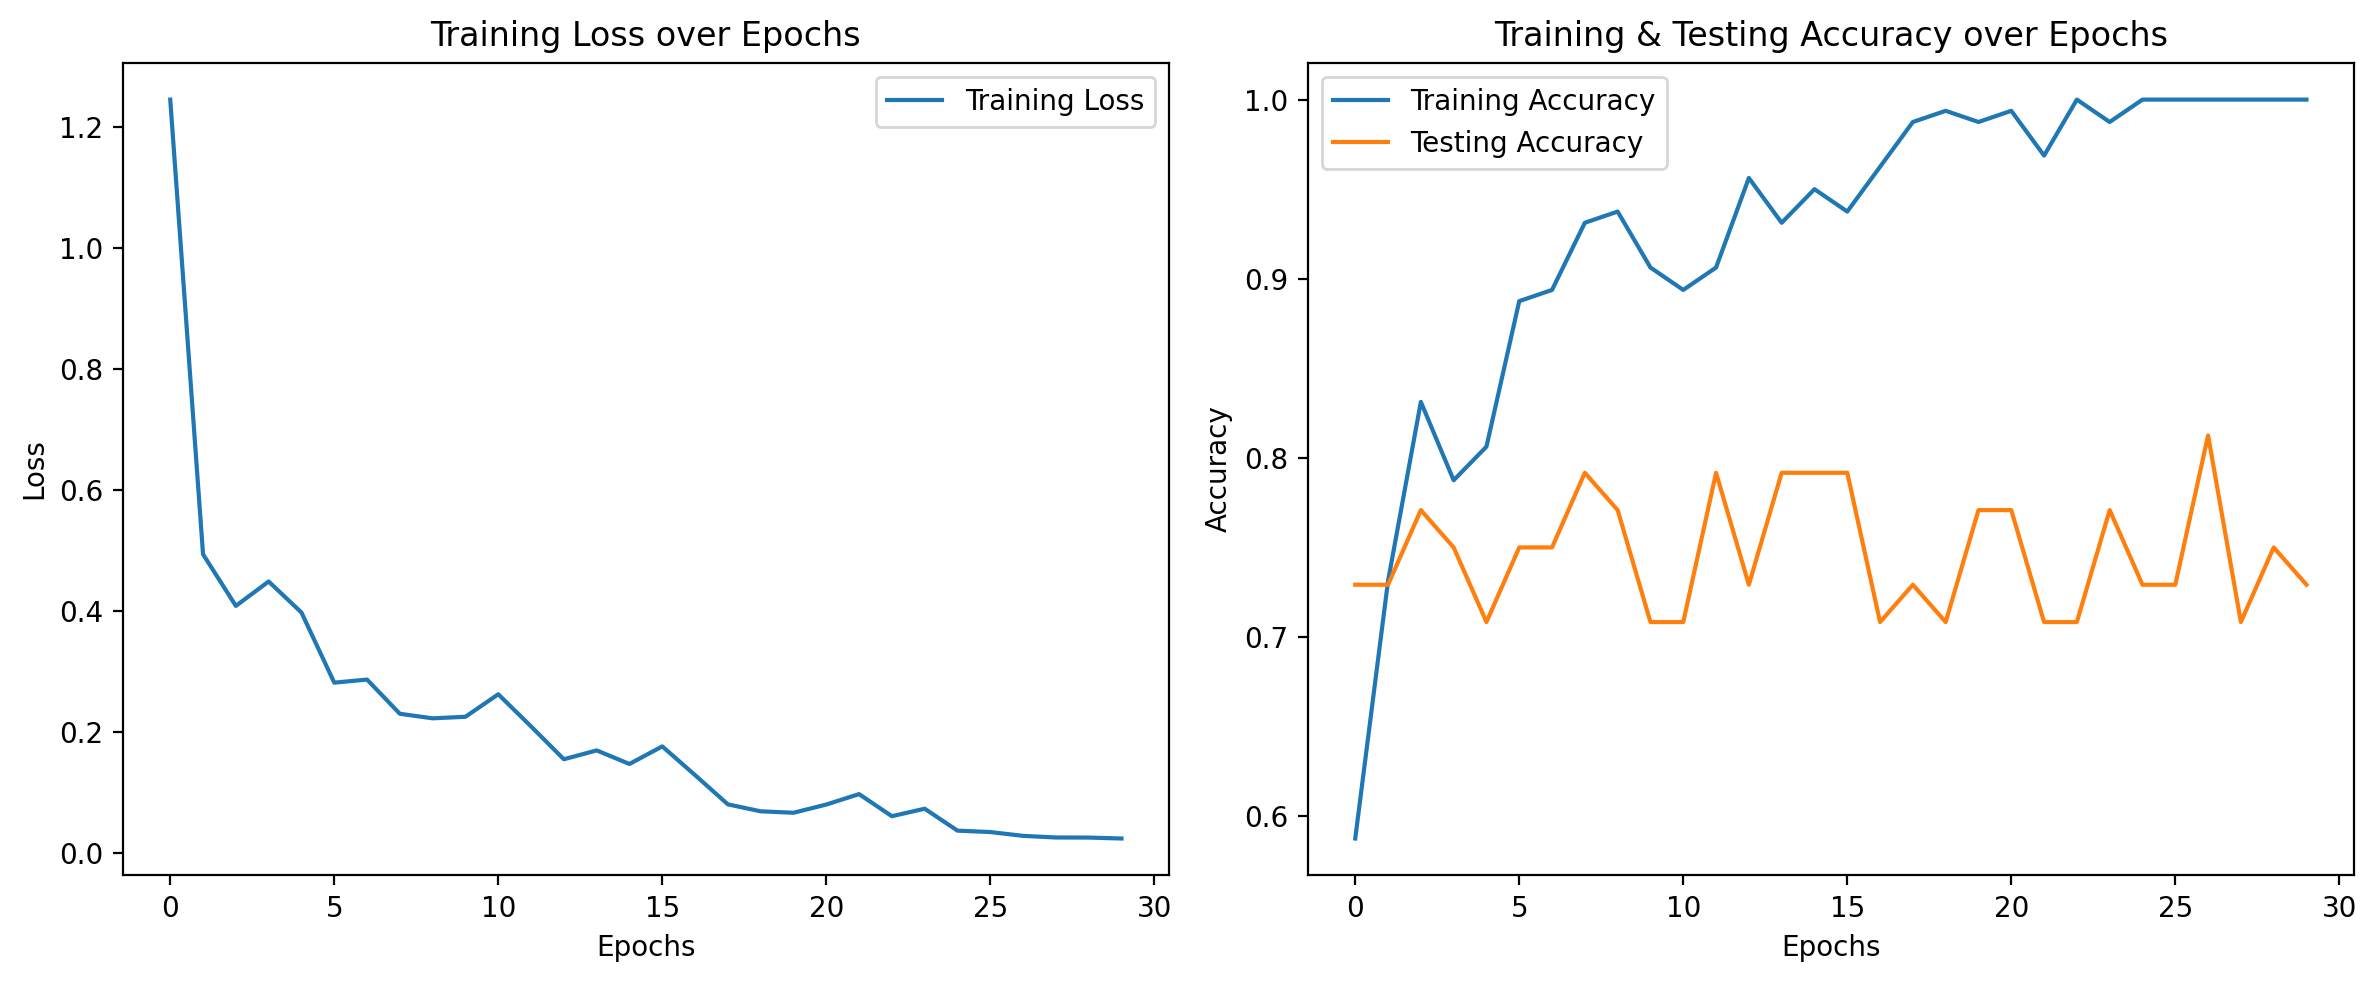

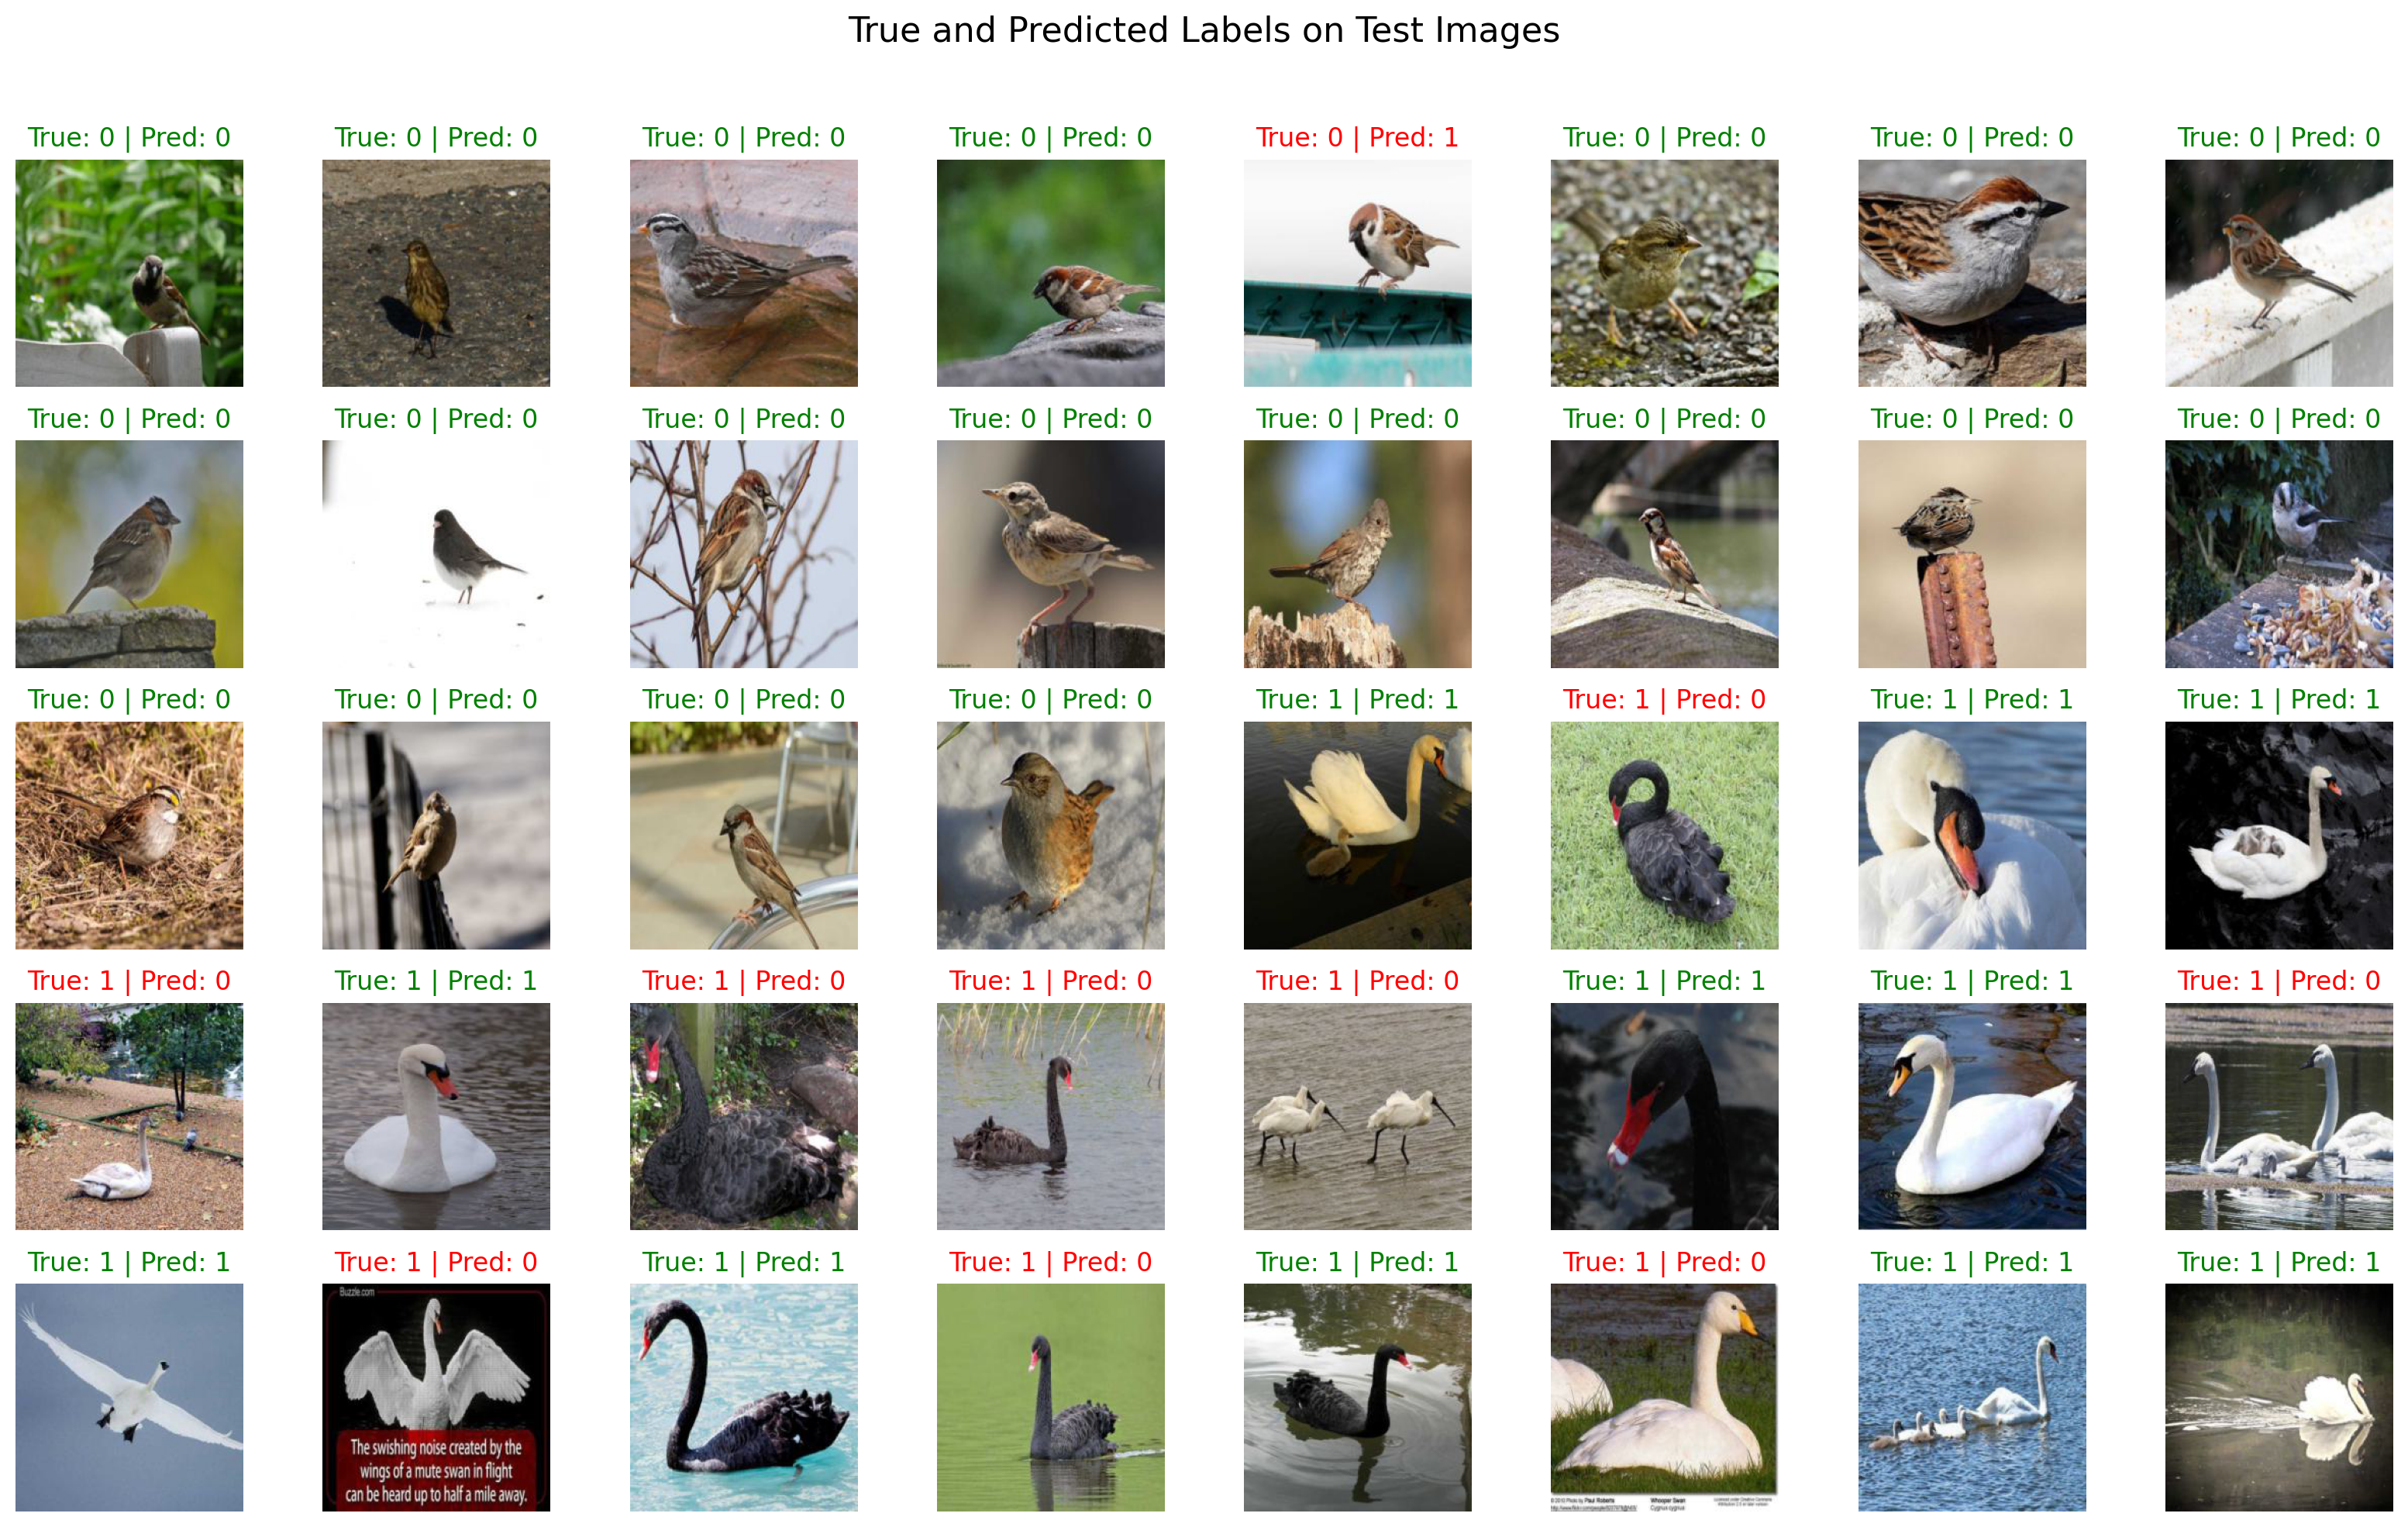

Accuracy: 75.00%


In [12]:
model = VGG1Block()
train_losses , train_accuracies,test_accuracies = train_and_evaluate(model,train_loader, test_loader,num_epochs = 30, batch_size = 16, learning_rate = 1e-4)
# Call plot_metrics to show the loss and accuracy curves
plot_metrics(train_losses, train_accuracies, test_accuracies)

# Call plot_test_predictions to log test images and confusion matrix to TensorBoard
true_labels, predicted_labels = plot_test_predictions(
    model, test_loader, num_images=40, device='cuda' if torch.cuda.is_available() else 'cpu'
)

### VGG 3 Block

In [13]:
# class VGG3Block(nn.Module):
#     def __init__(self, num_classes=1):
#         super(VGG3Block, self).__init__()
        
#         # First Block: Conv2D(32) -> ReLU -> MaxPool
#         self.block1 = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv Layer with 32 filters
#             nn.ReLU(),  # ReLU Activation
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
#         )
        
#         # Second Block: Conv2D(64) -> ReLU -> MaxPool
#         self.block2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv Layer with 64 filters
#             nn.ReLU(),  # ReLU Activation
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
#         )
        
#         # Third Block: Conv2D(128) -> ReLU -> MaxPool
#         self.block3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer with 128 filters
#             nn.ReLU(),  # ReLU Activation
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with 2x2 kernel
#         )
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(128 * 28 * 28, 128)  # Flattened size after convolution
#         self.fc2 = nn.Linear(128, num_classes)  # Output layer for binary classification
#         self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification output
        
#     def forward(self, x):
#         # Pass input through the convolutional blocks
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
        
#         # Flatten the output from convolutional layers
#         x = x.view(x.size(0), -1)
        
#         # Pass through the fully connected layers
#         x = self.fc1(x)
#         x = torch.relu(x)  # ReLU activation in the dense layer
#         x = self.fc2(x)
#         x = self.sigmoid(x)  # Final sigmoid activation for binary classification
#         return x

# # Example of using the model
# model_3block = VGG3Block(num_classes=1)

# # Print the model summary (for input size 224x224x3)
# from torchsummary import summary
# summary(model_3block, input_size=(3, 224, 224))


In [14]:
# from torchvision import transforms

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(30),
#     transforms.RandomResizedCrop(224),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Random Perspective
#     transforms.RandomGrayscale(p=0.2),  # Random Grayscale with probability
#     transforms.RandomErasing(p=0.5),  # Random Erasing with 50% probability
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
 